In [5]:
import pandas as pd
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
import time
import swifter # For Parallel computing and use MultiThread 

from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy
import seaborn as sns
import matplotlib.pyplot as plt



In [6]:
df=pd.read_csv("C:/Users/pctes/Downloads/DANA_PROJECTS/DANA_4840/data_2.csv")
df_labels=pd.read_csv("C:/Users/pctes/Downloads/DANA_PROJECTS/DANA_4840/labels.csv")

In [62]:
df.tail()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
796,sample_796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,sample_797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,sample_798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,sample_799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000
800,sample_800,0.0,2.325242,3.805932,6.530246,9.560367,0.0,7.957027,0.000000,0.0,...,6.403075,8.594354,10.243079,9.139459,10.102934,11.641081,10.607358,9.844794,4.550716,0.000000


In [3]:
df_labels.tail()

NameError: name 'df_labels' is not defined

In [70]:
# Let's check if both labels have the same names 
list_labels=df_labels.iloc[:,0].tolist()
list_df=df.iloc[:,0].tolist()
print((list_labels)==(list_df))

True


In [7]:
# Class column was sent to the end of the columns 
df_merged=df.merge(df_labels,on="Unnamed: 0",how="left")


In [8]:
column_list_df=df.columns.tolist()

In [9]:
# Now we are moving Class column to the first position 
df_merged=df_merged[["Class"] + column_list_df]

In [7]:
df_merged.head()

,Class,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,PRAD,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,LUAD,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,PRAD,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,PRAD,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,BRCA,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [12]:
# We are dropping the Unnamed column
df_merged.drop(columns=["Unnamed: 0"],inplace=True)

In [14]:
# Save merged:file

df_merged.to_csv("df_merged.csv",index=False)

In [13]:
df_merged.head()

,Class,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,PRAD,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,LUAD,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,PRAD,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,PRAD,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,BRCA,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [8]:
# Exploratory Data Analysis

df_merged_copy=df_merged.copy()


In [9]:
df_merged["Class"].unique()
# Labels  5 classes: BRCA, KIRC, COAD, LUAD, and PRAD




array(['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD'], dtype=object)

#### PRAD: PRAD stands for Prostate Adenocarcinoma. It refers to cancers that arise in the prostate gland.
#### LUAD: LUAD stands for Lung Adenocarcinoma. It refers to cancers that arise in the lung tissue.
#### BRCA: BRCA stands for Breast Cancer. Specifically, it refers to cancers that arise in breast tissue.
#### KIRC: KIRC stands for Kidney Renal Clear Cell Carcinoma. 
#### COAD: COAD stands for Colon Adenocarcinoma. It refers to cancers that arise in the colon.




In [58]:
#  Beginning of Exploratory Data Analysis
# There is only one Object Column ,the rest are numerical values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [15]:
# Let's see the distribution of the data across CLASS columns
df_merged.groupby("Class").size()

Class
BRCA    300
COAD     78
KIRC    146
LUAD    141
PRAD    136
dtype: int64

In [45]:
# I am going to group  them based on their class and plot an histogram to see the distribution of the data
df_merged.head()

df_merged.groupby("Class").plot(kind="hist",subplots=True,figsize=(10,10))

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001F625BEC2C0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001F638B8E660> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [41]:
df_pivot=pd.pivot_table(df_merged,index=["Class"],aggfunc="mean")
df_pivot

# We are comparing the mean of all genes acros the classes to plot and compare any discrepancy 

,gene_0,gene_1,gene_10,gene_100,gene_1000,gene_10000,gene_10001,gene_10002,gene_10003,gene_10004,...,gene_9990,gene_9991,gene_9992,gene_9993,gene_9994,gene_9995,gene_9996,gene_9997,gene_9998,gene_9999
Class,,,,,,,,,,,,,,,,,,,,,
BRCA,0.011362,2.839739,0.544066,10.681488,10.303568,3.258028,7.339461,7.900497,7.489146,7.508378,...,1.969278,5.142237,1.736160,2.312551,1.696127,2.493789,0.046527,2.099709,0.151063,6.954733
COAD,0.022212,3.438381,0.357278,11.015745,9.951124,3.462039,5.526673,7.487396,3.783493,6.959238,...,2.216178,0.354828,1.833606,1.619692,3.839205,2.396207,0.090327,2.298246,0.065007,6.618466
KIRC,0.046544,2.398129,1.166824,10.238999,11.148094,1.651798,6.895752,7.686932,7.269611,7.636246,...,1.824964,0.596508,2.393303,1.872888,1.289448,3.139623,0.130416,2.387948,0.148641,6.429343
LUAD,0.041088,3.358260,0.607541,10.517670,10.503698,3.754181,7.281878,7.041924,6.145042,7.148682,...,2.609490,2.801700,2.738326,1.869805,2.217144,2.459608,0.042070,2.281828,0.056608,6.721517
PRAD,0.026544,3.441041,0.765608,10.282936,9.967433,1.949878,7.946141,8.529695,5.696368,7.396572,...,1.623491,4.594215,1.684084,2.588050,1.703772,3.568490,0.572893,3.621548,0.094953,7.104225


In [77]:
df_pivot.shape[0]

5

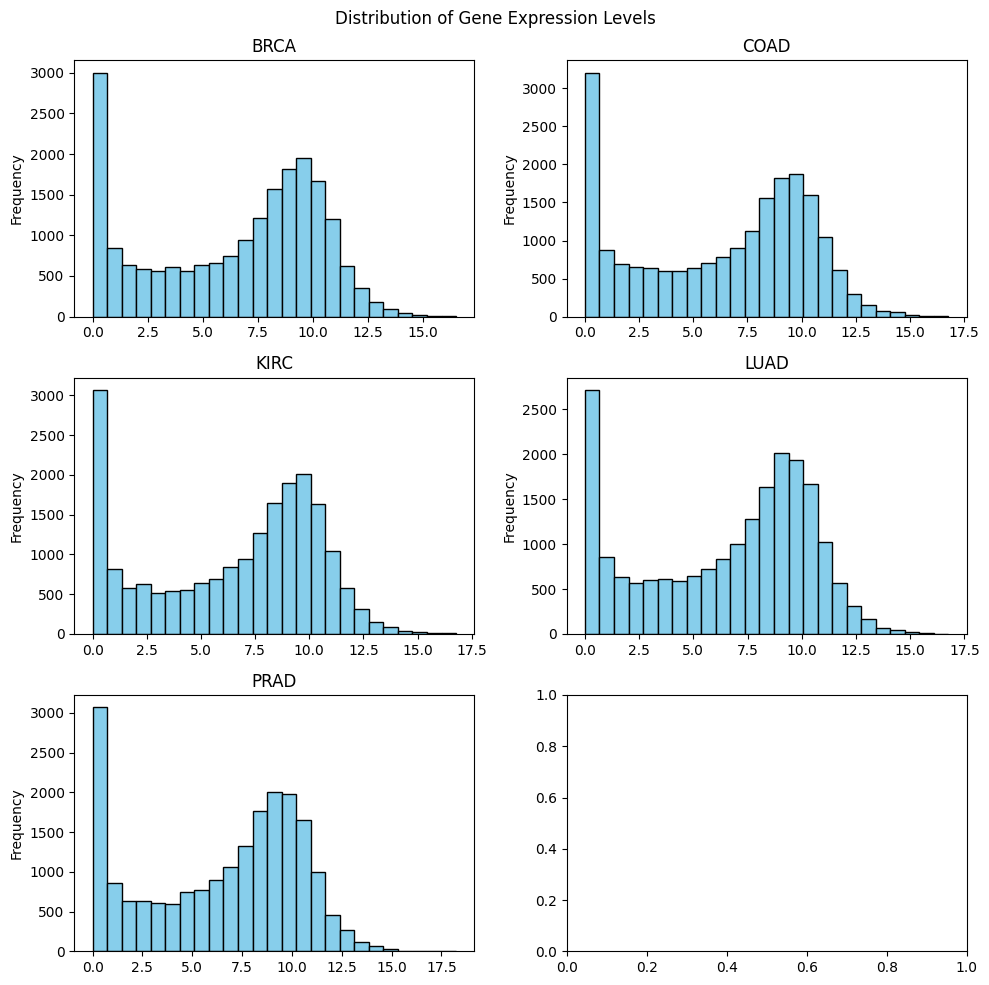

In [82]:
# We will use the mean of the all samples across the genes to see the distribution of the data across the classes
# We will make subplot of the histogram to see the distribution of the data across the classes

cancer_names = df_pivot.index.tolist()
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle('Distribution of Gene Expression Levels')
for i, ax in enumerate(cancer_names):
    df_pivot.loc[ax].plot(kind="hist", ax=axes[i//2, i%2], title=ax,color='skyblue', edgecolor='black',bins=25)    
plt.tight_layout()
plt.show()
    
#df_brca=df_pivot.loc["BRCA"]



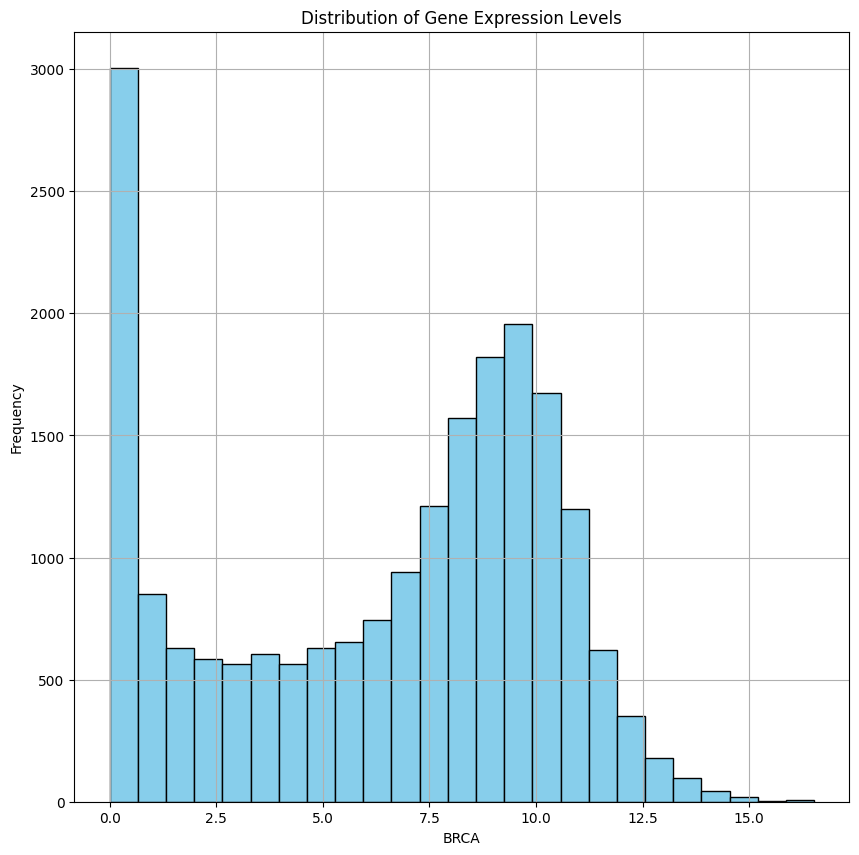

In [70]:
# Let's see the distribution of the BRCA
plt.figure(figsize=(10,10))
plt.hist(df_brca,bins=25, color='skyblue', edgecolor='black')
plt.xlabel('BRCA')
plt.ylabel('Frequency')
plt.title('Distribution of Gene Expression Levels')
plt.grid(True)

In [17]:
# Let's scale the data before doing PCA

df_numerical=df_merged.iloc[:,1:]
scaler = StandardScaler()
scaled_data=scaler.fit_transform(df_numerical)

In [46]:
scaled_data.shape

(801, 20531)

In [37]:
# Let's Perform PCA to dimension reduction and see the relationship between the genes
# We will use a  Scree plot to see the variance explained by the principal components

pca = PCA(n_components=15,svd_solver='full')
X_pca=pca.fit_transform(scaled_data)

print(pca.explained_variance_ratio_)


[0.10539781 0.08754232 0.07810081 0.05165647 0.04028932 0.02920881
 0.02354735 0.02145299 0.01632001 0.01233899 0.01054096 0.00894552
 0.00850433 0.00752984 0.00666611]


In [38]:
# pca.explained_variance_ provides the actual variance explained by each principal component, while pca.explained_variance_ratio_ provides the proportion of variance explained by each principal component relative to the total variance in the data. 

import numpy as np
np.cumsum(pca.explained_variance_ratio_)

array([0.10539781, 0.19294014, 0.27104095, 0.32269742, 0.36298674,
       0.39219555, 0.4157429 , 0.43719589, 0.4535159 , 0.4658549 ,
       0.47639585, 0.48534137, 0.4938457 , 0.50137554, 0.50804164])

In [39]:
pca.explained_variance_

array([2138.4510195 , 1776.17511467, 1584.61311767, 1048.07516639,
        817.44324014,  592.62724714,  477.75999283,  435.26681234,
        331.12214046,  250.3499398 ,  213.86892113,  181.49851978,
        172.54708679,  152.77539019,  135.25082944])

In [40]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Print cumulative variance explained
for i, variance in enumerate(cumulative_variance):
    print(f"Cumulative Variance explained by first {i+1} principal component(s): {variance:.4f}")

Cumulative Variance explained by first 1 principal component(s): 0.1054
Cumulative Variance explained by first 2 principal component(s): 0.1929
Cumulative Variance explained by first 3 principal component(s): 0.2710
Cumulative Variance explained by first 4 principal component(s): 0.3227
Cumulative Variance explained by first 5 principal component(s): 0.3630
Cumulative Variance explained by first 6 principal component(s): 0.3922
Cumulative Variance explained by first 7 principal component(s): 0.4157
Cumulative Variance explained by first 8 principal component(s): 0.4372
Cumulative Variance explained by first 9 principal component(s): 0.4535
Cumulative Variance explained by first 10 principal component(s): 0.4659
Cumulative Variance explained by first 11 principal component(s): 0.4764
Cumulative Variance explained by first 12 principal component(s): 0.4853
Cumulative Variance explained by first 13 principal component(s): 0.4938
Cumulative Variance explained by first 14 principal componen

In [57]:
explained_variance=pca.explained_variance_

components_to_keep=explained_variance>15
print("Components to keep based on eigenvalue criterion:", components_to_keep.sum())
print("Eigenvalue: ", explained_variance)
# 

Components to keep based on eigenvalue criterion: 182
Eigenvalue:  [2.13845102e+03 1.77617511e+03 1.58461312e+03 1.04807517e+03
 8.17443240e+02 5.92627247e+02 4.77759993e+02 4.35266812e+02
 3.31122140e+02 2.50349940e+02 2.13868921e+02 1.81498520e+02
 1.72547087e+02 1.52775390e+02 1.35250829e+02 1.31259710e+02
 1.23483814e+02 1.18704881e+02 1.07404796e+02 1.04589379e+02
 9.92673005e+01 9.45145277e+01 9.23160896e+01 9.08223582e+01
 8.62029773e+01 8.48374742e+01 8.16496506e+01 7.98602232e+01
 7.92096995e+01 7.27752763e+01 7.25511691e+01 7.10082131e+01
 6.84437270e+01 6.74666517e+01 6.58733966e+01 6.49512836e+01
 6.27388725e+01 5.98929272e+01 5.78299464e+01 5.68908854e+01
 5.62293057e+01 5.45671169e+01 5.39781462e+01 5.29635555e+01
 5.25214391e+01 5.18530327e+01 5.11778691e+01 5.05548832e+01
 4.94683049e+01 4.82602384e+01 4.74321832e+01 4.66014247e+01
 4.60119855e+01 4.56325620e+01 4.41225556e+01 4.36133693e+01
 4.32312139e+01 4.27619328e+01 4.15535334e+01 4.14391288e+01
 4.05497119e+01 4.

In [35]:
# Eigenvalue plot to see the variance explained by the principal components

plt.plot(range(1, 1001), explained_variance, marker='o', linestyle='--')

NameError: name 'explained_variance' is not defined

In [20]:
sum(explained_variance)

NameError: name 'explained_variance' is not defined

In [24]:
# Compute the distance matrix
# 2min and 52 seconds
transposed_data=scaled_data.T
#dist=pdist(transposed_data,metric="euclidean")

In [22]:
transposed_data=pd.DataFrame(transposed_data)

In [16]:
# Calculate the distances between the genes
distances=pdist(transposed_data,metric="euclidean")

# 1 min and 15 sec

In [17]:
from joblib import Parallel, delayed
def calculate_distances(data):
    return pdist(data, metric="euclidean")

parallel_results = Parallel(n_jobs=-1)(delayed(calculate_distances)(transposed_data) for _ in range(1))
# It took the same time using parallel computing as normal computing
# 1 min and 17 sec


In [28]:
# After we calculate the distances, we will convert the distances to a square matrix
dist_matrix=squareform(distances)
dist_matrix


#  Squareform/condensed saves memory by only representing the upper triangular points, whereas uncondensed is the full matrix.

# Remember that converting a condensed matrix to a square matrix can consume more memory, especially for large datasets, so use it judiciously based on your specific needs.

array([[ 0.        , 39.53952492, 39.47858548, ..., 40.99664959,
        39.18457393, 40.57686808],
       [39.53952492,  0.        , 27.32560202, ..., 34.70979034,
        41.35326638, 39.33159002],
       [39.47858548, 27.32560202,  0.        , ..., 38.66693573,
        39.78885513, 38.48223116],
       ...,
       [40.99664959, 34.70979034, 38.66693573, ...,  0.        ,
        38.89001177, 41.02593018],
       [39.18457393, 41.35326638, 39.78885513, ..., 38.89001177,
         0.        , 39.67206624],
       [40.57686808, 39.33159002, 38.48223116, ..., 41.02593018,
        39.67206624,  0.        ]])

In [46]:
# Now that we have the distance scaled matrix, we will use the hierarchical clustering to see the relationship between the genes



In [48]:
# This is the equivalent In R studio

# distances <- dist(t(data), method = "euclidean")
# Compute hierarchical clustering linkage matrix
#linkage_matrix <- hclust(distances, method = "ward.D2")
# Plot dendrogram
#plot(linkage_matrix, hang = -1, main = "Hierarchical Clustering Dendrogram")

['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD']


In [ ]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy="mean")

# this will make it possible to impute missing values not only on the training set, but
# also on the validation set, the test set, and any new data fed to the model.

# housing_num = housing.select_dtypes(include=[np.number])
# imputer.fit(housing_num)
# X = imputer.transform(housing_num)

# KNNImputer replaces each missing value with the mean of the k-nearest neighbors’
# values for that feature. The distance is based on all the available features.

In [ ]:
# To change the categorical variables to numerical 
#from sklearn.preprocessing import OrdinalEncoder
#ordinal_encoder = OrdinalEncoder()
# housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [57]:
# We will implement CLARA instead of K means to see the relationship between the variables

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


C:\Users\pctes\AppData\Local\Temp\ipykernel_20136\571717318.py:19: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_square, method='average')


<Figure size 1000x600 with 0 Axes>

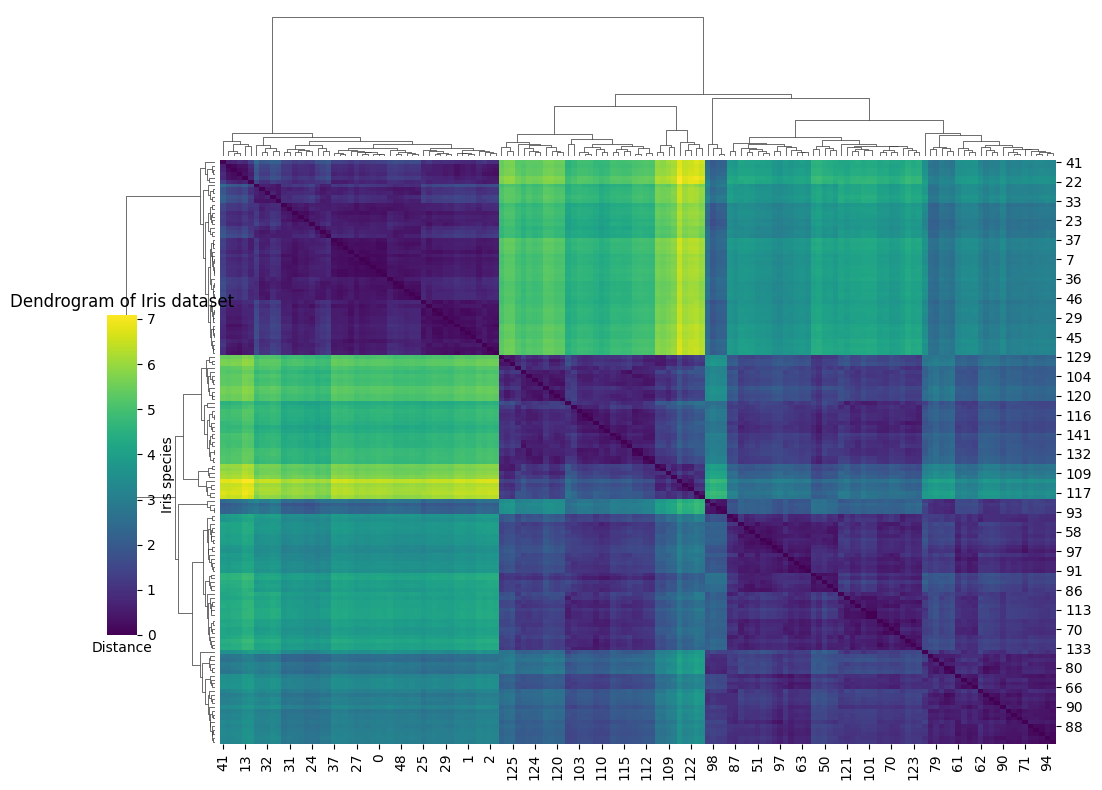

In [110]:

# We will implement CLARA instead of K means to see the relationship between the variables


